## 1. Modulus of the exit velocity, some features of Orbit #2

First, using the data available in the reports, we try to compute some of the properties of orbit #2. This is not enough to completely define the trajectory, but will give us information later on in the process.

In [1]:
from astropy import units as u

In [2]:
T_ref = 150 * u.day
T_ref

<Quantity 150. d>

In [3]:
from poliastro.bodies import Earth, Sun, Venus

In [4]:
k = Sun.k
k

<<class 'astropy.constants.constant.Constant'> name='Heliocentric gravitational constant' value=1.32712442099e+20 uncertainty=10000000000.0 unit='m3 / s2' reference='IAU 2009 system of astronomical constants'>

In [5]:
import numpy as np

$$ T = 2 \pi \sqrt{\frac{a^3}{\mu}} \Rightarrow a = \sqrt[3]{\frac{\mu T^2}{4 \pi^2}}$$

In [6]:
a_ref = np.cbrt(k * T_ref**2 / (4 * np.pi**2)).to(u.km)
a_ref.to(u.au)

<Quantity 0.55249526 AU>

$$ \varepsilon = -\frac{\mu}{r} + \frac{v^2}{2} = -\frac{\mu}{2a} \Rightarrow v = +\sqrt{\frac{2\mu}{r} - \frac{\mu}{a}}$$

In [7]:
energy_ref = (-k / (2 * a_ref)).to(u.J / u.kg)
energy_ref

<Quantity -8.02837549e+08 J / kg>

In [8]:
from poliastro.twobody import Orbit

In [9]:
from poliastro.util import norm

In [10]:
from astropy.time import Time

In [11]:
flyby_1_time = Time("2018-09-28", scale="tdb")
flyby_1_time

<Time object: scale='tdb' format='iso' value=2018-09-28 00:00:00.000>

In [12]:
r_mag_ref = norm(Orbit.from_body_ephem(Venus, epoch=flyby_1_time).r)
r_mag_ref.to(u.au)

<Quantity 0.72573132 AU>

In [13]:
v_mag_ref = np.sqrt(2 * k / r_mag_ref - k / a_ref)
v_mag_ref.to(u.km / u.s)

<Quantity 28.96736351 km / s>

---

## 2. Lambert arc between #0 and #1

To compute the arrival velocity to Venus at flyby #1, we have the necessary data to solve the boundary value problem.

In [14]:
d_launch = Time("2018-08-11", scale="tdb")
d_launch

<Time object: scale='tdb' format='iso' value=2018-08-11 00:00:00.000>

In [15]:
ss0 = Orbit.from_body_ephem(Earth, d_launch)
ss1 = Orbit.from_body_ephem(Venus, epoch=flyby_1_time)

In [16]:
tof = flyby_1_time - d_launch

In [17]:
from poliastro import iod

In [18]:
(v0, v1_pre), = iod.lambert(Sun.k, ss0.r, ss1.r, tof.to(u.s))

In [19]:
v0

<Quantity [ 9.59933726, 11.29855172,  2.92449333] km / s>

In [20]:
v1_pre

<Quantity [-16.98082099,  23.30752839,   9.13129077] km / s>

In [21]:
norm(v1_pre)

<Quantity 30.24846495 km / s>

---

## 3. Flyby #1 around Venus

We compute a flyby using poliastro with the default value of the entry angle, just to discover that the results do not match what we expected.

In [22]:
from poliastro.threebody.flybys import compute_flyby

In [23]:
V = Orbit.from_body_ephem(Venus, epoch=flyby_1_time).v
V

<Quantity [ 648499.73735241, 2695078.44750227, 1171563.7170508 ] km / d>

In [24]:
h = 2548 * u.km

In [25]:
d_flyby_1 = Venus.R + h
d_flyby_1.to(u.km)

<Quantity 8599.8 km>

In [26]:
V_2_v_, delta_ = compute_flyby(v1_pre, V, Venus.k, d_flyby_1)

In [27]:
norm(V_2_v_)

<Quantity 27.75533877 km / s>

## 4. Optimization

Now we will try to find the value of $\theta$ that satisfies our requirements.

In [28]:
def func(theta):
    V_2_v, _ = compute_flyby(v1_pre, V, Venus.k, d_flyby_1, theta * u.rad)
    ss_1 = Orbit.from_vectors(Sun, ss1.r, V_2_v, epoch=flyby_1_time)
    return (ss_1.period - T_ref).to(u.day).value

In [29]:
import matplotlib.pyplot as plt

There are two solutions:

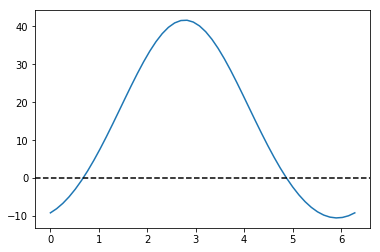

In [30]:
theta_range = np.linspace(0, 2 * np.pi)
plt.plot(theta_range, [func(theta) for theta in theta_range])
plt.axhline(0, color='k', linestyle="dashed")

In [31]:
func(0)

-9.142672330001131

In [32]:
func(1)

7.09811543934556

In [33]:
from scipy.optimize import brentq

In [34]:
theta_opt_a = brentq(func, 0, 1) * u.rad
theta_opt_a.to(u.deg)

<Quantity 38.59870925 deg>

In [35]:
theta_opt_b = brentq(func, 4, 5) * u.rad
theta_opt_b.to(u.deg)

<Quantity 279.34770004 deg>

In [36]:
V_2_v_a, delta_a = compute_flyby(v1_pre, V, Venus.k, d_flyby_1, theta_opt_a)
V_2_v_b, delta_b = compute_flyby(v1_pre, V, Venus.k, d_flyby_1, theta_opt_b)

In [37]:
norm(V_2_v_a)

<Quantity 28.96736351 km / s>

In [38]:
norm(V_2_v_b)

<Quantity 28.96736351 km / s>

## 5. Exit orbit

And finally, we compute orbit #2 and check that the period is the expected one.

In [39]:
ss01 = Orbit.from_vectors(Sun, ss1.r, v1_pre, epoch=flyby_1_time)
ss01

0 x 1 AU x 18.8 deg orbit around Sun (☉)

<div class="alert alert-warning"><strong>Note</strong>: The two solutions have different inclinations. We still have to find out which is the good one. We could do this by computing the inclination over the ecliptic or visualizing the geometry of the flyby, since both are known.</div>

In [40]:
ss_1_a = Orbit.from_vectors(Sun, ss1.r, V_2_v_a, epoch=flyby_1_time)
ss_1_a

0 x 1 AU x 25.0 deg orbit around Sun (☉)

In [41]:
ss_1_b = Orbit.from_vectors(Sun, ss1.r, V_2_v_b, epoch=flyby_1_time)
ss_1_b

0 x 1 AU x 13.1 deg orbit around Sun (☉)

In [42]:
ss_1_a.period.to(u.day)

<Quantity 150. d>

In [43]:
ss_1_a.a

<Quantity 82652114.57939689 km>

In [44]:
ss_1_b.period.to(u.day)

<Quantity 150. d>

In [45]:
ss_1_b.a

<Quantity 82652114.57939698 km>

In [46]:
from poliastro.plotting import OrbitPlotter

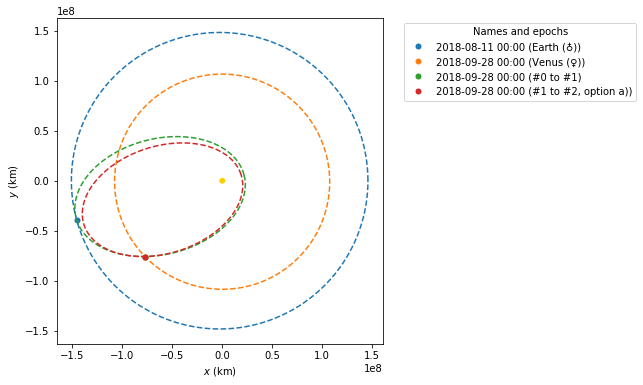

In [47]:
frame = OrbitPlotter()

frame.plot(ss0, label=Earth)
frame.plot(ss1, label=Venus)
frame.plot(ss01, label="#0 to #1")
frame.plot(ss_1_a, label="#1 to #2, option a)");
#frame.plot(ss_1_b, label="#1 to #2, option b)");